# Capstone Project

### 2016 U.S. POTUS Primary Election

In [1]:
import sys
import pandas as pd
#pd.set_option('display.max_rows', 1300)
import numpy as np
import matplotlib.pyplot as pl
import networkx as nx
import pygraphviz
import seaborn as sns
import sqlite3
import time
import pydot
import os
import time

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
from StringIO import StringIO
from io import BytesIO
from IPython.display import Image 
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
%sqlite_execute 

ERROR: Line magic function `%sqlite_execute` not found.


In [3]:
%load_ext sql

In [4]:
%load_ext sql
%sql sqlite:///database.sqlite
try:    
    db = sqlite3.connect('database.sqlite')
    c = db.cursor()
    print "Successfully connected to the database"
except IntegrityError:
    print"Did not successfully connect to database"

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
Successfully connected to the database


### SQL Commands:

In [ ]:
%sql SELECT * FROM primary_results

%sql ALTER TABLE primary_results ADD COLUMN county_state TEXT;
%sql UPDATE primary_results SET county_state = (county || "_" || state_abbreviation);
%sql UPDATE primary_results SET candidate = Replace(candidate,' ','_');

'''Create Republican Table:'''
%sql CREATE TABLE Republicans AS SELECT * FROM primary_results;
%sql DELETE FROM Republicans WHERE(party ='Democrat') 

'''Create Democrat Table:'''
%sql CREATE TABLE Democrats AS SELECT * FROM primary_results;
%sql DELETE FROM Democrats WHERE(party ='Republican') 

'''Update County Facts Table:'''
%sql UPDATE county_facts SET state_abbreviation = NULL WHERE state_abbreviation = '';
%sql DELETE FROM county_facts WHERE state_abbreviation IS NULL;
%sql ALTER TABLE county_facts ADD COLUMN county_state TEXT;
%sql UPDATE county_facts SET area_name = SUBSTR(area_name,1, LENGTH(area_name)-7);
%sql UPDATE county_facts SET county_state = (area_name || "_" || state_abbreviation);
%sql UPDATE county_facts SET county_state = REPLACE(county_state,'"','');

#Output County_Facts_Description as CSV file (.mode csv)
#%sql .output county_facts_dict.csv # command in terminal


'''SQL TABLES FOR TO GROUP WINNER OF EACH COUNTY:'''

#Identify the Republican winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Republicans GROUP BY county ORDER BY state;
%sql CREATE TABLE Republican_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import republican_winners.csv Republican_Winner

#Identify the Democrat winner in each county:
%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Democrats GROUP BY county ORDER BY state;
%sql CREATE TABLE Democrat_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import democrat_winners.csv Democrat_Winner 

# Join Tables (county_facts and Republican/Democrat winner)
%sql SELECT * FROM Republican_Winner INNER JOIN county_facts WHERE Republican_Winner.county_state = county_facts.county_state;
%sql SELECT * FROM Democrat_Winner INNER JOIN county_facts WHERE Democrat_Winner.county_state = county_facts.county_state;

### Explore Data:

In [5]:
# Generate Dataframe
df_primary_results = pd.read_sql_query('SELECT * FROM primary_results', db) #Primary Results 
df_county_facts = pd.read_sql_query('SELECT * FROM county_facts',db) #County Facts
df_republicans = pd.read_sql_query('SELECT * FROM Republicans',db) # Republican Table
df_democrats = pd.read_sql_query('SELECT * FROM Democrats', db) # Democrat Table

#County Facts Dictionary:
df_county_facts_dictionary = pd.read_sql_query('SELECT * FROM county_facts_dictionary ',db)

In [6]:
# Republican Primary results
df_republicans.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,county_state
0,Alabama,AL,Autauga,1001,Republican,Donald_Trump,5387,0.445,Autauga_AL
1,Alabama,AL,Autauga,1001,Republican,Ted_Cruz,2482,0.205,Autauga_AL
2,Alabama,AL,Autauga,1001,Republican,Marco_Rubio,1785,0.148,Autauga_AL
3,Alabama,AL,Autauga,1001,Republican,Ben_Carson,1764,0.146,Autauga_AL
4,Alabama,AL,Autauga,1001,Republican,John_Kasich,421,0.035,Autauga_AL


In [7]:
# Republican Primary results
df_democrats.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,county_state
0,Alabama,AL,Autauga,1001,Democrat,Hillary_Clinton,2387,0.800,Autauga_AL
1,Alabama,AL,Autauga,1001,Democrat,Bernie_Sanders,544,0.182,Autauga_AL
2,Alabama,AL,Baldwin,1003,Democrat,Hillary_Clinton,5290,0.647,Baldwin_AL
3,Alabama,AL,Baldwin,1003,Democrat,Bernie_Sanders,2694,0.329,Baldwin_AL
4,Alabama,AL,Barbour,1005,Democrat,Hillary_Clinton,2567,0.906,Barbour_AL


In [8]:
# County Facts data
df_county_facts.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,county_state
0,1001,Autauga,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,31.7,0,0,598175,12003,88157,131,594.44,91.8,Autauga_AL
1,1003,Baldwin,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6,Baldwin_AL
2,1005,Barbour,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,27.0,0,0,188337,6334,0,8,884.88,31.0,Barbour_AL
3,1007,Bibb,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,0.0,0,0,124707,5804,10757,19,622.58,36.8,Bibb_AL
4,1009,Blount,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,23.2,341544,0,319700,5622,20941,3,644.78,88.9,Blount_AL


In [9]:
#shape of tables:
prim = df_primary_results.shape[0]
rep = df_republicans.shape[0]
dem = df_democrats.shape[0]
print "Primary Results:"
print "Total Number of Elements = {}; Republican: {}, Democrat :{}".format(prim,rep,dem)
print "Number of Features =", df_primary_results.shape[1]

#County Facts (shape):
print "\nCounty Facts:"
print "Total Number of Elements =", df_county_facts.shape[0]
print "Number of Features =", df_county_facts.shape[1] -4


Primary Results:
Total Number of Elements = 13212; Republican: 9152, Democrat :4060
Number of Features = 9

County Facts:
Total Number of Elements = 3143
Number of Features = 51


### Summary of Primary Results

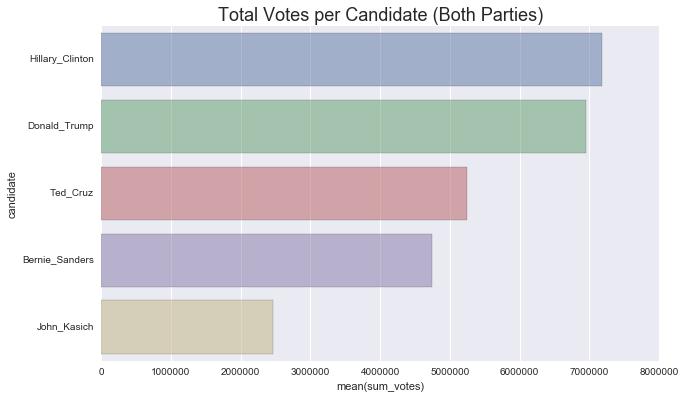

In [10]:
votes_sum = pd.read_sql_query('SELECT candidate, party, sum(votes) as sum_votes \
    FROM primary_results GROUP BY candidate, party ORDER BY sum_votes desc, party;',db)
#Candidate who suspended campaign: (drop from df)
to_del = votes_sum.loc[votes_sum['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul',
    'Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',
    "Martin_O'Malley",'Marco_Rubio','_No_Preference','_Uncommitted'])].index.tolist()
votes = votes_sum.drop(to_del)

#Plots
sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes, alpha=0.5)
sns.plt.title('Total Votes per Candidate (Both Parties)', fontsize = 18)


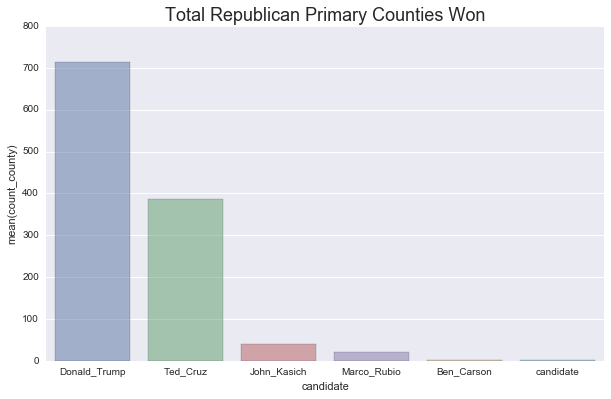

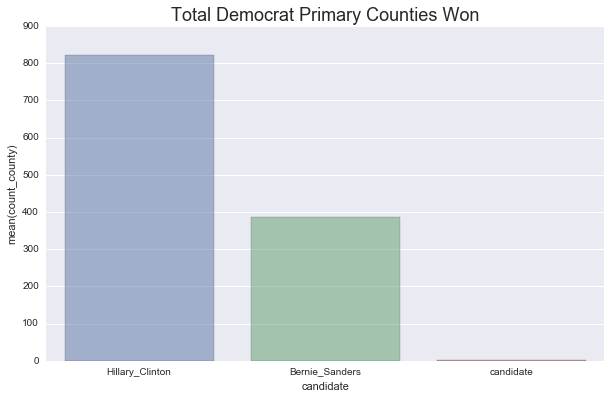

In [11]:
# republican winner by county:
rep_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Republican_Winner GROUP BY candidate ORDER BY count_county desc', db)
# democrat winner by county:
dem_winner_county = pd.read_sql_query('SELECT candidate, count(candidate) \
    as count_county FROM Democrat_Winner GROUP BY candidate ORDER BY count_county desc', db)

#plots
sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = rep_winner_county, alpha = 0.5)
sns.plt.title('Total Republican Primary Counties Won', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(x = 'candidate', y = 'count_county', data = dem_winner_county, alpha=0.5)
sns.plt.title('Total Democrat Primary Counties Won', fontsize = 18)


### Preprocess Data:


In [12]:
#Dataframe for Republican winners per county w/ county facts:
democrat_data = pd.read_csv("democrat_winners_county_facts.csv")
#drop repeated columns from merge
democrat_data.drop(democrat_data.columns[[1,3,9,10,11,63]], axis=1, inplace=True)

#Dataframe for Republican winners per county w/ county facts:
republican_data = pd.read_csv("republican_winners_county_facts.csv")
#drop repeated columns from merge
republican_data.drop(republican_data.columns[[1,3,9,10,11,63]], axis=1, inplace=True)

# Remove all rows wrt Republican candidates who suspended campaign:
to_del = republican_data.loc[republican_data['candidate'].isin(['Jeb_Bush', 
    'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum',
    'Mike_Huckabee',"Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
republican_data = republican_data.drop(to_del)


In [ ]:
#RENAME COLUMNS: 
#remove commentted out section below to rename headers for the feature columns

#republican_data or democrat_data = republican_data.rename(columns = {
#               'PST045214':'Population 2014',
#                'PST040210':'Population 2010',
#                'PST120214':'Delta Pop (%) 2014',
#                'POP010210':'Population 2010',
#                'AGE135214':'Under 5',
#                'AGE295214':'Under 18',
#                'AGE775214':'Age > 65',
#                'SEX255214':'Female (%)',
#                'RHI125214':'White (%)',
#                'RHI225214':'Black (%)',
#                'RHI325214':'American Indian (%)',
#                'RHI425214':'Asian (%)',
#                'RHI525214':'Native Hawaiian (%)',
#                'RHI625214':'2+ Races (%)',
#                'RHI725214':'Hispanic (%)',
#                'RHI825214':'White alone (%)',
#                'POP715213':'Living same house 1+yr over (%)',
#                'POP645213':'Foreign born (%)',
#                'POP815213':'Other Languages (%)',
#                'EDU635213':'High School Degree',
#                'EDU685213':'College Degree',
#                'VET605213':'Veterans',
#                'LFE305213':'Mean travel time to work (minutes, Age>16+)',
#                'HSG010214':'Housing Units',
#                'HSG445213':'Homeownership rate',
#                'HSG096213':'Housing units in multi-unit structures (%)',
#                'HSG495213':'Med value of owner-occupied housing units (%)',
#                'HSD410213':'Households',
#                'HSD310213':'Persons per household',
#                'INC910213':'Yr. Per capita income ($)',
#                'INC110213':'Median household income ($)',
#                'PVY020213':'below poverty level (%)',
#                'BZA010213':'Private nonfarm establishments',
#                'BZA110213':'Private nonfarm employment',
#                'BZA115213':'Private nonfarm employment delta%)',
#                'NES010213':'Nonemployer establishments',
#                'SBO001207':'Total Firms',
#                'SBO315207':'Black-owned firms (%)',
#                'SBO115207':'American Indian owned firms, (%)',
#                'SBO215207':'Asian-owned firms, (%)',
#                'SBO515207':'Native Hawaiian owned firms (%)',
#                'SBO415207':'Hispanic-owned firms (%)',
#                'SBO015207':'Women-owned firms (%)',
#                'MAN450207':'Manufacturers shipments($1k)',
#                'WTN220207':'Merchant wholesaler sales ($1k)',
#                'RTN130207':'Retail sales, ($1k)',
#                'RTN131207':'Retail sales per capita',
#                'AFN120207':'Accomm & food services sales ($1K)',
#                'BPS030214':'Building permits',
#                'LND110210':'Land area in square miles',
#                'POP060210':'Population per sqmile'})

In [13]:
'''Democrats'''
x_columns_dem = list(democrat_data.columns[8:]) 
x_vars_dem = democrat_data[x_columns_dem] # Features
y_vars_dem = democrat_data['candidate'] # Target Labels
df_dem = pd.concat([x_vars_dem,y_vars_dem],axis=1) #combine Feautres/Target into one dataframe
df_dem.drop(df_dem.columns[[3,4]],axis=1, inplace=True) #Remove Ages under 5 and 18


In [14]:
'''Republicans'''
#republican_data = republican_data.replace(['Donald_Trump','Ted_Cruz','John_Kasich'],[1,2,3])
x_columns_rep = list(republican_data.columns[8:]) 
x_vars_rep = republican_data[x_columns_rep] # Features
y_vars_rep = republican_data['candidate'] # Target Labels
df_rep = pd.concat([x_vars_rep,y_vars_rep],axis=1) #combine Feautres/Target into one dataframe
df_rep.drop(df_rep.columns[[3,4]],axis=1, inplace=True) #Remove Ages under 5 and 18


### Explore the data

In [15]:
def plot1():
    x_feat = "RHI125214"
    y_feat = "EDU685213"
    x_label = "White (%)"
    y_label = "Education (BS or Higher)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)

def plot2():
    x_feat = "INC910213"
    y_feat = "EDU685213"
    x_label = "Per Capita Money Income ($)"
    y_label = "Education (BS or Higher)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot3():
    x_feat = "INC110213"
    y_feat = "RHI225214"
    x_label = "Median household income ($)"
    y_label = "Black or African American (%)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot4():
    x_feat = "INC110213"
    y_feat = "RHI125214"
    x_label = "Median household income ($)"
    y_label = "White (%)"
    dem_create_plot(x_feat,y_feat,x_label,y_label)
    
def dem_create_plot(x_feat,y_feat,x_label,y_label):
    hue = "candidate"
    dataframe = democrat_data
    markerSize = (democrat_data['votes']/200)
    g = sns.lmplot(x=x_feat, y=y_feat, data=dataframe, hue=hue, 
               scatter_kws={'s':markerSize,'alpha':0.7,'linewidths':1.5,'edgecolor':'w'},
                   size=5.5, aspect=1.5)
    g.set_xlabels(x_label, size = 18)
    g.set_ylabels(y_label, size = 18)
    axes = g.axes
    g.set(ylim=(0,None))
    g.set(xlim=(0,None))
    sns.plt.title('Democrat Party', fontsize = 20)

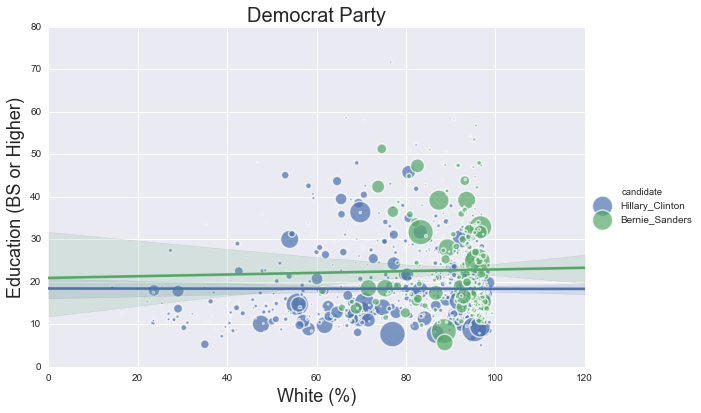

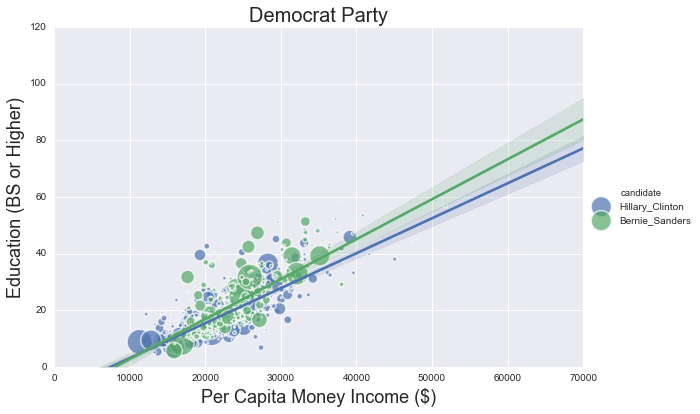

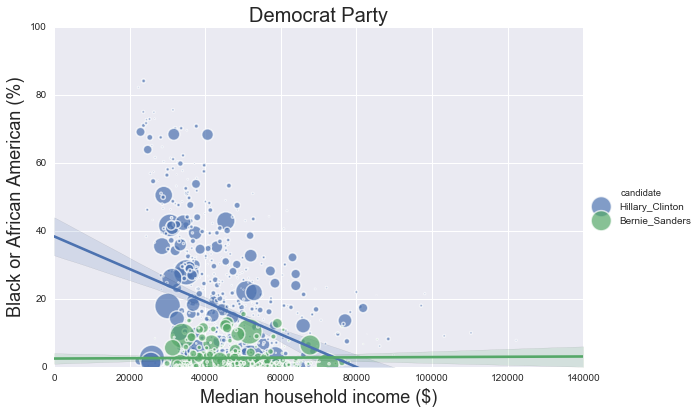

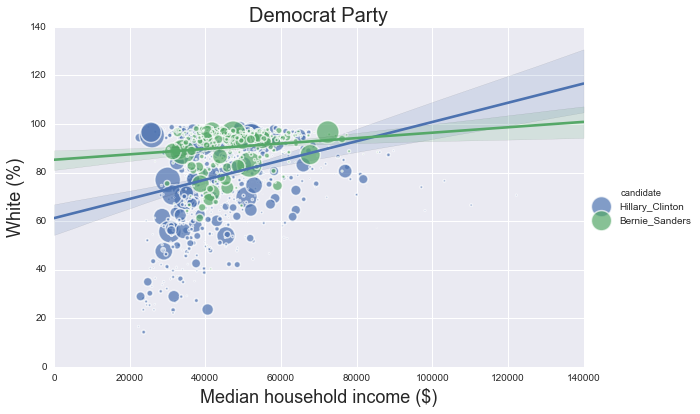

In [16]:
#Republicans
def main():
    plot1()
    plot2()
    plot3()
    plot4()
if __name__ == "__main__":
    main()

### Republican Party

In [17]:
def plot1():
    x_feat = "RHI125214"
    y_feat = "EDU685213"
    x_label = "White (%)"
    y_label = "Education (BS or Higher)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

def plot2():
    x_feat = "INC910213"
    y_feat = "EDU685213"
    x_label = "Per Capita Money Income ($)"
    y_label = "Education (BS or Higher)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot3():
    x_feat = "INC110213"
    y_feat = "RHI225214"
    x_label = "Median household income ($)"
    y_label = "Black or African American (%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)
    
def plot4():
    x_feat = "INC110213"
    y_feat = "RHI125214"
    x_label = "Median household income ($)"
    y_label = "White (%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

def plot5():
    x_feat = "INC110213"
    y_feat = "RHI725214"
    x_label = "Median household income ($)"
    y_label = "Hispanic(%)"
    rep_create_plot(x_feat,y_feat,x_label,y_label)

    
def rep_create_plot(x_feat,y_feat,x_label,y_label):
    hue = "candidate"
    dataframe = republican_data
    markerSize = (republican_data['votes']/200)
    g = sns.lmplot(x=x_feat, y=y_feat, data=dataframe, hue=hue, 
               scatter_kws={'s':markerSize,'alpha':0.7,'linewidths':1.5,'edgecolor':'w'},
                   size=5.5, aspect=1.5)
    g.set_xlabels(x_label, size = 18)
    g.set_ylabels(y_label, size = 18)
    axes = g.axes
    g.set(ylim=(0,100))
    g.set(xlim=(0,None))
    sns.plt.title('Republican Party', fontsize = 20)



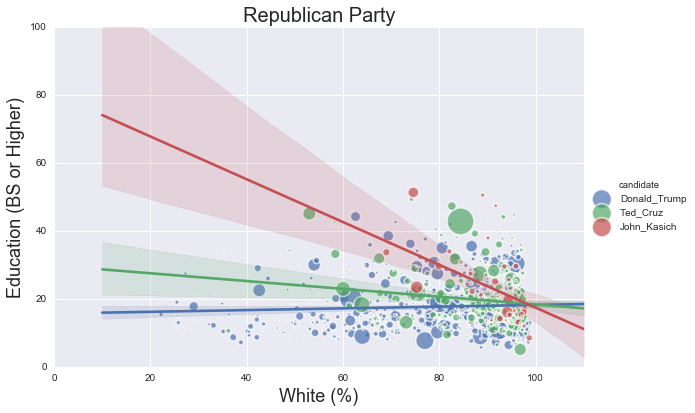

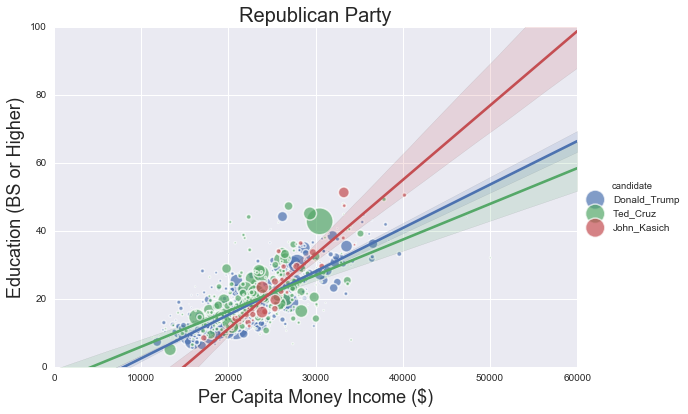

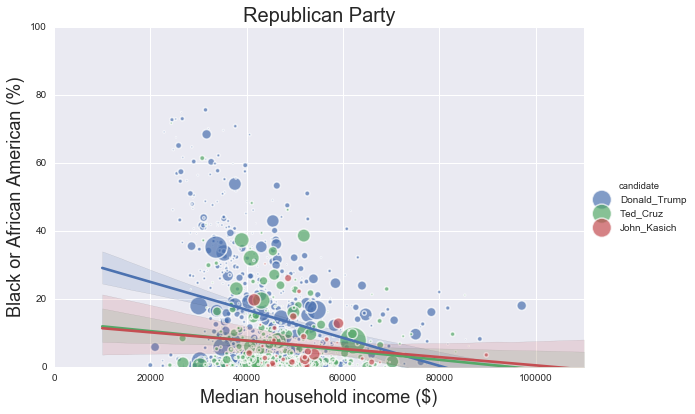

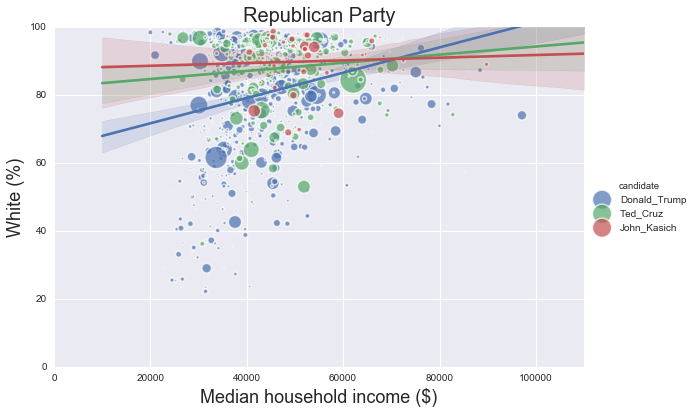

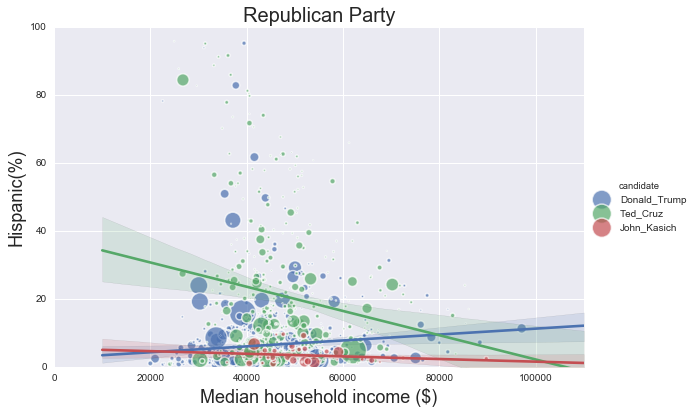

In [18]:
#Republicans
def main():
    plot1()
    plot2()
    plot3()
    plot4()
    plot5()
if __name__ == "__main__":
    main()

# Calibrate Predictive Model

### Split Training/Testing Set

In [19]:
feature_cols = list(df_rep.columns[:-1])  # all columns but last are features
target_col = df_rep.columns[-1]  # last column is the target/label

X_all = df_rep[feature_cols]  # feature values 
y_all = df_rep[target_col]  # corresponding targets/labels
num_all = df_rep.shape[0]
num_train = int(num_all - (num_all*.25))
num_test = num_all - num_train

def Stratified_Shuffle_Split(X,y,num_test):
    sss = StratifiedShuffleSplit(y, 10, test_size=num_test, random_state = 42)
    for train_index, test_index in sss:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
print "Training Set: {0:.2f} Samples".format(X_train.shape[0])
print "Testing Set: {0:.2f} Samples".format(X_test.shape[0])


Training Set: 848.00 Samples
Testing Set: 283.00 Samples


### Decision Tree: Classification

In [20]:
def Decision_Tree():
    n_depth = []
    accuracy = []
    for depth in range (1,11):
        clf = tree.DecisionTreeClassifier(max_depth = depth, 
        min_samples_split = 20, min_samples_leaf = 20, random_state=None)
        if clf.fit(X_train,y_train).tree_.max_depth < depth:
            break
        score = np.mean(cross_val_score(clf,X_train,y_train,
                scoring ='accuracy', n_jobs=1))
        scoring = round(score,4)
        accuracy.append(scoring)
        n_depth.append(depth)
        print 'Depth: %i Accuracy: %.4f' % (depth,score)
    DT_max_depth_plot(accuracy,n_depth)

def DT_max_depth_plot(accuracy,n_depth):
    pl.figure(figsize=(8,6))
    pl.plot(n_depth, accuracy, label = "Accuracy")
    pl.title("Decision Tree: Max_Depth", fontsize = 18)
    pl.xlabel("max_depth", fontsize =14)
    pl.ylabel("Accuracy", fontsize =14)
    pl.xlim(1,10)
    pl.legend(loc = "upper right")
    pl.tight_layout()
    pl.show()

Depth: 1 Accuracy: 0.7264
Depth: 2 Accuracy: 0.7252
Depth: 3 Accuracy: 0.7335
Depth: 4 Accuracy: 0.7429
Depth: 5 Accuracy: 0.7406
Depth: 6 Accuracy: 0.7382
Depth: 7 Accuracy: 0.7371
Depth: 8 Accuracy: 0.7382


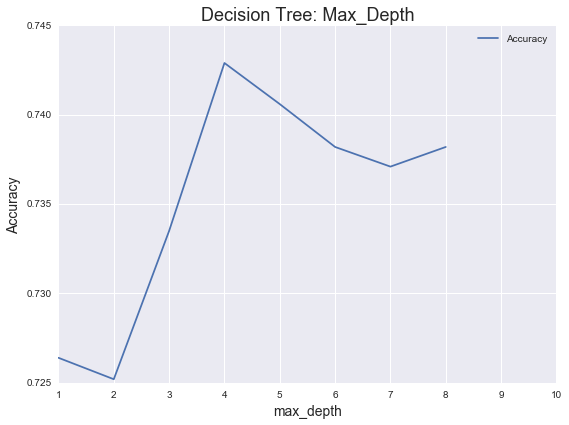

In [21]:
Decision_Tree()

In [22]:
def DT_tune_model(number_runs):
    f1_scores = []
    clf_dt = tree.DecisionTreeClassifier()
    for num in range(0, number_runs):
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        start = time.time()
        '''Parameters:'''
        parameters = {'max_depth':list(range(2,10)),
                    'min_samples_leaf':(2,4,6,8,10,15,20,25,30),
                    'min_samples_split':(2,4,6,8,10,15,20,25,30)}
        #grid_search 
        clf_grid_search = GridSearchCV(clf_dt, parameters, scoring = 'f1')
        
        #Fit classifier to training data:
        clf_grid_search.fit(X_train,y_train)
        #Predict model on testing data:
        pred = clf_grid_search.predict(X_test)
        
        #Record total run time:
        end = time.time()
        total_time = end - start
        m, s = divmod(total_time, 60)
        h, m = divmod(m, 60)
        print "Total Time: %d:%02d:%02d \n" % (h, m, s)
        
        '''Classification Report:'''
        class_report = classification_report(y_test, pred)
        print "Classification Report:"
        print class_report
        
        '''F1 Score'''
        f1_scores.append(f1_score(y_test, pred, average='weighted'))
        
        '''Grid Search Best Parameters:'''
        best_parameters = clf_grid_search.best_estimator_.get_params()
        print '\nBest Parameters:'
        for param_name in sorted(parameters.keys()):
            print '\t%s: %r' % (param_name, best_parameters[param_name])
    
    df = pd.Series(f1_scores)
    print "\nF1 Score:"
    print df

In [23]:
DT_tune_model(1)

Total Time: 0:00:42 

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.78      0.84      0.81       177
John_Kasich       0.50      0.30      0.37        10
   Ted_Cruz       0.70      0.64      0.67        96

avg / total       0.74      0.75      0.74       283


Best Parameters:
	max_depth: 7
	min_samples_leaf: 6
	min_samples_split: 25

F1 Score:
0    0.743843
dtype: float64


### Construct Decision Tree

Apr 16 22:51:34 Trace-Smiths-MacBook-Pro.local dot[1996] <Error>: The function ‘CGFontGetGlyphPath’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.
Apr 16 22:51:34 Trace-Smiths-MacBook-Pro.local dot[1996] <Error>: The function ‘CGFontGetGlyphPaths’ is obsolete and will be removed in an upcoming update. Unfortunately, this application, or a library it uses, is using this obsolete function, and is thereby contributing to an overall degradation of system performance.



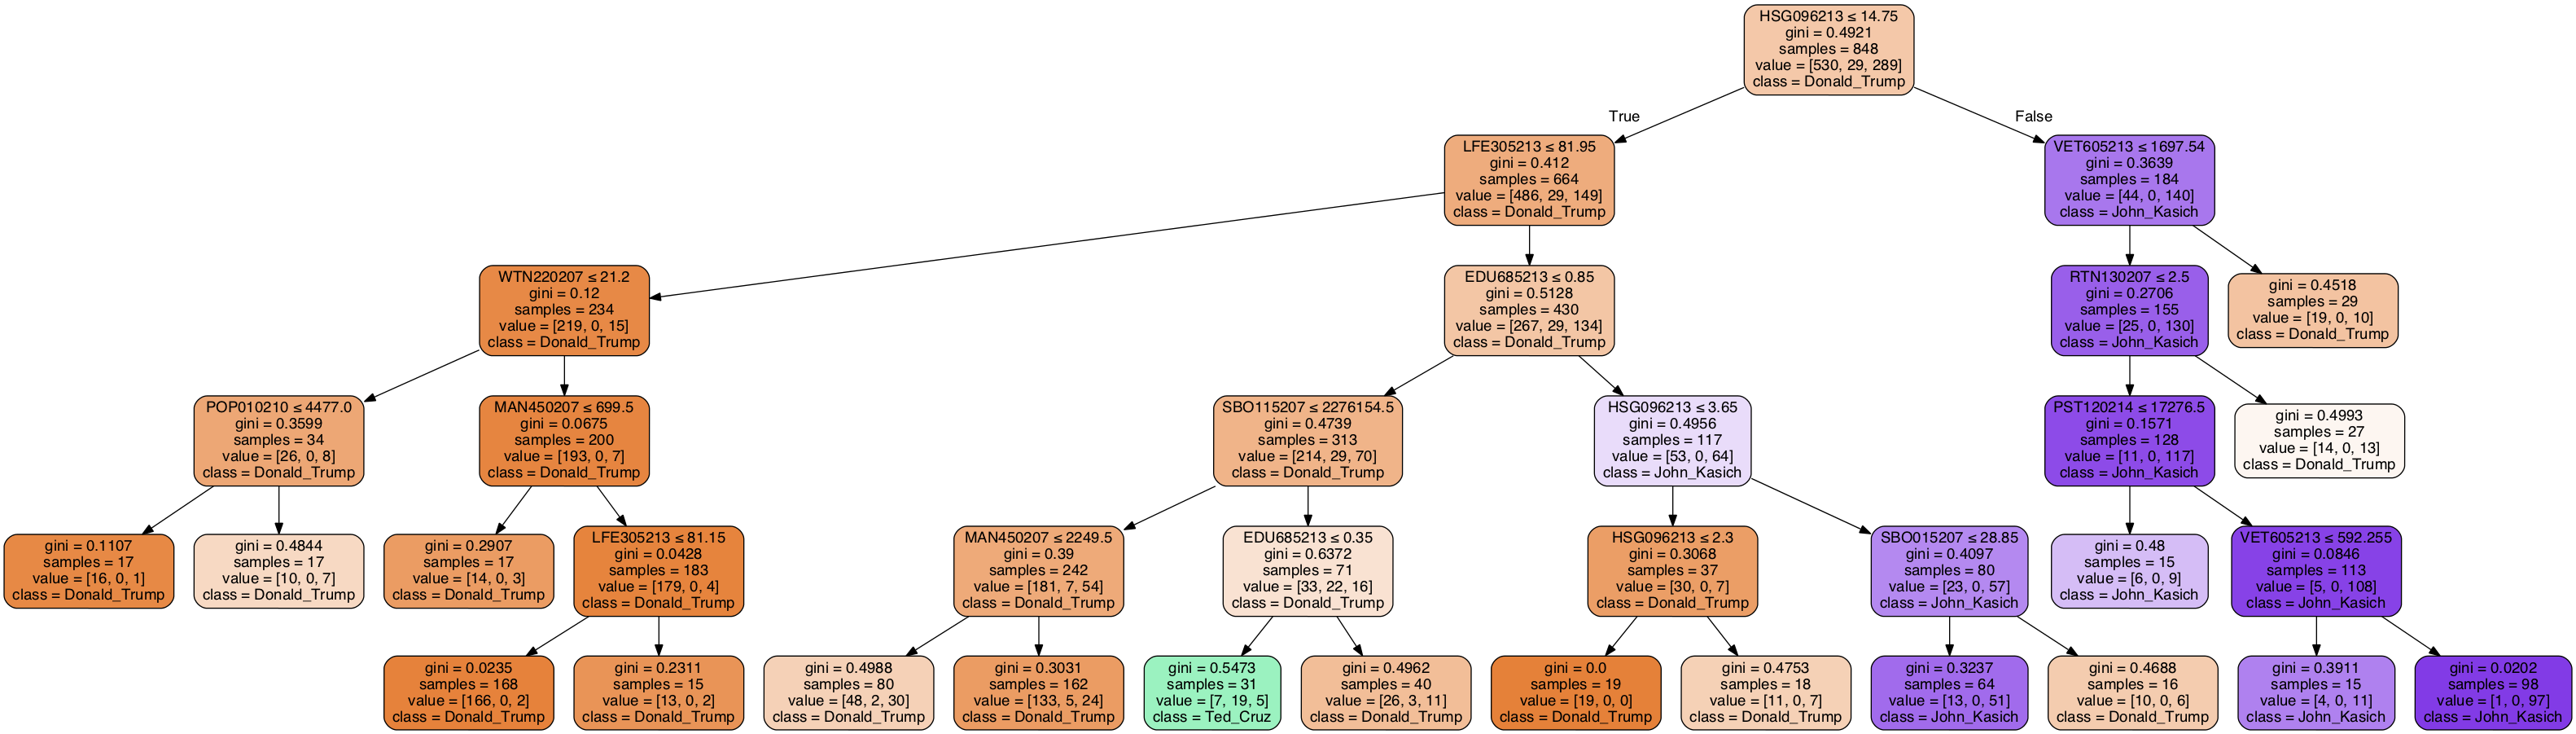

In [24]:
clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split=10,min_samples_leaf=15)
clf = clf.fit(X_train, y_train)
    
'''Replace candidate value with name:'''
    #df_rep.ix[df_rep.candidate == 1, 'candidate'] = 'Donald_Trump'
    #df_rep.ix[df_rep.candidate == 2, 'candidate'] = 'Ted_Cruz'
    #df_rep.ix[df_rep.candidate == 3, 'candidate'] = 'John_Kasich'
    
'''Add Labels to Features'''
df_rep_dt = df_rep
    #df_rep_dt.drop('candidate',axis=1,inplace = True) #drop target column
list_of_dic = df_rep_dt.T.to_dict().values()
vec = DictVectorizer()
vec.fit_transform(list_of_dic).toarray()
feature_names = vec.get_feature_names()
    
'''Add Target Labels'''
target_names = ['Donald_Trump','Ted_Cruz','John_Kasich']

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
        
os.unlink('tree.dot')
    
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data,feature_names=vec.get_feature_names(),  
                             class_names=target_names) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf") 


dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                             feature_names=vec.get_feature_names(),  
                             class_names=target_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### Random Forest

In [25]:
#classifier:
clf_RF = RandomForestClassifier(n_estimators=10)

#Train Classifier
def train_classifier(clf, X_train, y_train):
    print "{}:".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_clf_time = end - start
    print "Training Time (secs): {:.3f}".format(train_clf_time)
    return train_clf_time

#Predict Labels
def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prediction_time = end - start
    print "Prediction Time (secs): {:.3f}".format(prediction_time)
    return (f1_score(target.values, y_pred, pos_label= None, average = 'macro'), prediction_time)
    
# Train and Predict
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    train_diff = train_classifier(clf, X_train, y_train)
    
    # Train and predict training set:
    f1_score_train, pred_time_train = predict_labels(clf, X_train, y_train)
    print "F1 score for TRAINING set:",(f1_score_train)
    # Predict on test data set:
    f1_score_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print "F1 score for TEST set:",(f1_score_test)
    
    return (f1_score_train, f1_score_test, train_diff, pred_time_test)

#Run Model: (w/out Gridsearch)
def run_model(classifiers):
    names = feature_cols
    for clf in classifiers:
        df = pd.DataFrame(columns = [
                    'Training_Size',
                    'Testing_Size',
                    'Training_Time',
                    'Prediction_Time',
                    'F1_Score_Training',
                    'F1_Score_Testing'])

        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        
        num_times_to_run = 1
        sizes = [X_train.shape[0]] #can change training/testing size
        for size in sizes: 
            for x in range(0, num_times_to_run): 
                f1_score_train, f1_score_test, train_time, pred_time_test = train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
        
                '''Confusion Matrix: Testing Set'''
                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                print "\nConfusion Matrix:"
                print cm

                #Feature Importance:
                feature_imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
                reverse=True)      
                df = df.append({
                        'Training_Size': len(X_train[:size]),
                        'Testing_Size': X_test.shape[0],
                        'Training_Time': train_time,
                        'Prediction_Time': pred_time_test,
                        'F1_Score_Training': f1_score_train,
                        'F1_Score_Testing': f1_score_test}, 
                        ignore_index= True)
            
            #Feature Importance
            columns = ['Importance','Feature']
            df_imp = pd.DataFrame(feature_imp, columns = columns)
            
            #mean statistics:
            df = df[(df.Training_Size == size)]
            df_mean = df.mean()
            
            print "**********************************************************"
            print "Mean Statistics:"
            print df_mean
            print "**********************************************************"
            print "Feature Importance:"
            print df_imp
            print "**********************************************************"
    
    pl.figure
    feature_plot(df_imp)
        
def feature_plot(df_imp):
    ax = df_imp.plot(x='Feature', y='Importance',kind='bar',
        figsize=(15,10), color= 'b',
        alpha= 0.8, legend=True)
    ax.set_title('Feature Importance', fontsize = 24)
    ax.set_ylabel('Importance', fontsize= 16)
    ax.set_xlabel('Feature',fontsize= 16)
    pl.tight_layout()
    pl.show()


------------------------------------------
RandomForestClassifier:
Training Time (secs): 0.087
Prediction Time (secs): 0.004
F1 score for TRAINING set: 0.973448976565
Prediction Time (secs): 0.002
F1 score for TEST set: 0.609564259871

Confusion Matrix:
[[164   1  12]
 [  7   2   1]
 [ 41   0  55]]
**********************************************************
Mean Statistics:
Training_Size        848.000000
Testing_Size         283.000000
Training_Time          0.087311
Prediction_Time        0.002146
F1_Score_Training      0.973449
F1_Score_Testing       0.609564
dtype: float64
**********************************************************
Feature Importance:
    Importance    Feature
0       0.0755  RHI325214
1       0.0592  RHI725214
2       0.0552  LND110210
3       0.0549  POP815213
4       0.0371  POP060210
5       0.0315  RHI825214
6       0.0311  LFE305213
7       0.0285  HSG495213
8       0.0284  INC110213
9       0.0281  PVY020213
10      0.0281  AGE775214
11      0.0280  RHI225214


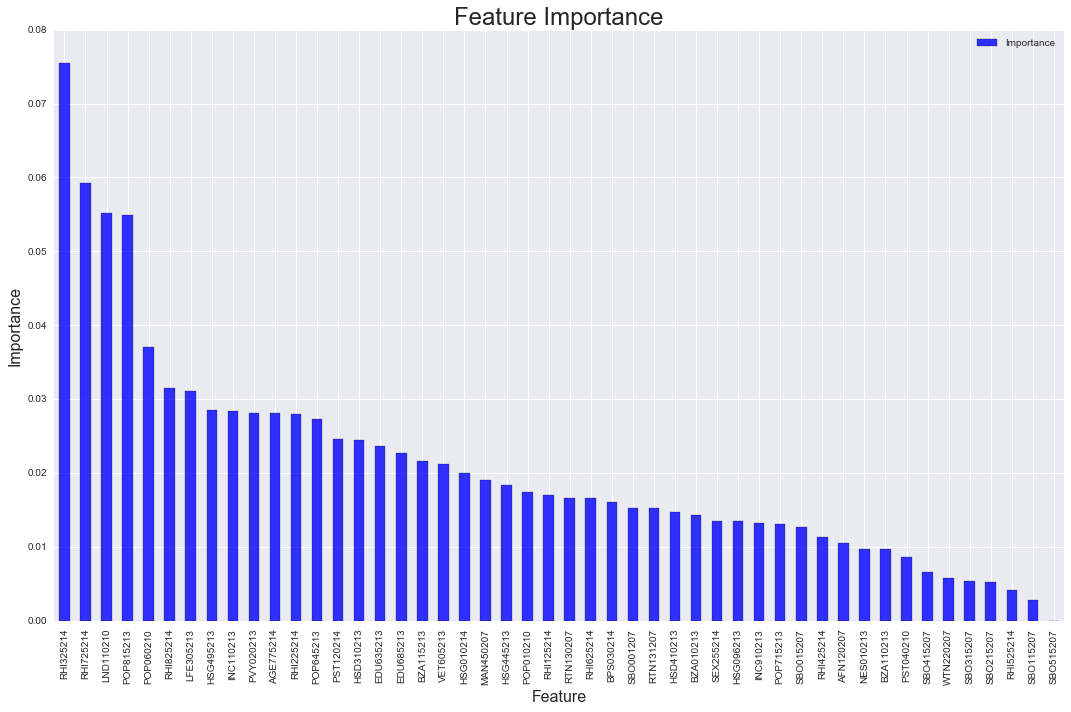

In [26]:
run_model([clf_RF])

### Number of Estimators: 

In [27]:
# Determining the optimal number of trees for Random Forest
def num_estimators():
    n_estimator = []
    error_rate = []
    min_estimator = 1
    max_estimator = 200
    X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
    sizes = [X_train.shape[0]] #can change training/testing size
    start = time.time()
    for size in sizes:
        for i in range(min_estimator, max_estimator):
            clf = RandomForestClassifier(max_features=None, oob_score=True,random_state=None)
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train).predict(X_test)
            oob_error = round((1 - clf.oob_score_),3)
            n_estimator.append(i)
            error_rate.append(oob_error)
    end = time.time()
    total_time = (end-start)
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    print "Total Time: %d:%02d:%02d" % (h, m, s) #hours:minutes:seconds
    #print n_estimator 
    #print error_rate
    pl.figure
    error_plot(n_estimator,error_rate,min_estimator,max_estimator)
    
def error_plot(n_estimator,error_rate,min_estimator,max_estimator):
        pl.figure(figsize=(8,6))
        pl.plot(n_estimator,error_rate, linewidth=3, color = 'g', label='Random Forrest')
        pl.ylim(0,.5)
        pl.xlim(min_estimator,max_estimator)
        pl.title('Random Forest: Error Rate', fontsize = 18)
        pl.xlabel("num_estimators", fontsize = 14)
        pl.ylabel("OOB Error Rate", fontsize = 14)
        pl.tight_layout()
        pl.legend(loc="upper right",fontsize =12)
        pl.show()

Total Time: 0:09:18


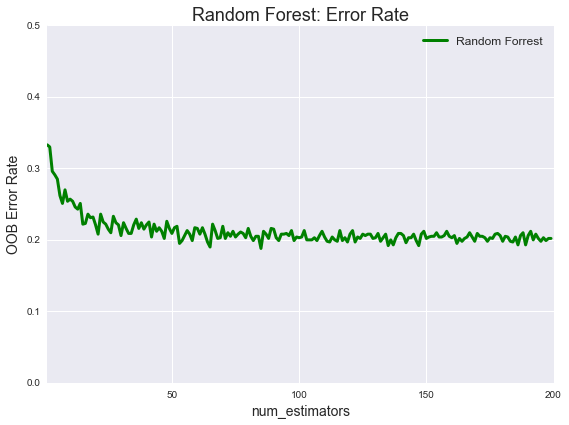

In [28]:
num_estimators()

### Fine Tune Model:

In [29]:
#Tune Model Using GridSearch
def RF_tune_model(number_runs):
    clf = RandomForestClassifier(n_estimators = 30)
    for num in range(0, number_runs):
        start = time.time()
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_all, y_all, num_test)
        
        '''Parameters:'''
        parameters = {'max_depth':list(range(2,10)),
                    'min_samples_leaf':(2,4,6,8,10,15,20,25,30),
                    'min_samples_split':(2,4,6,8,10,15,20,25,30)}
            
        #grid_search 
        clf_grid_search = GridSearchCV(clf, parameters, scoring = 'f1')
        
        #Fit classifier to training data:
        clf_grid_search.fit(X_train,y_train)
                
        #Predict model on testing data:
        predictions = clf_grid_search.predict(X_test)
        
        #Record total run time:
        end = time.time()
        total_time = end - start
        m, s = divmod(total_time, 60)
        h, m = divmod(m, 60)
        print "Total Time: %d:%02d:%02d \n" % (h, m, s)                                    
                                                     
        '''Classification Report:'''
        class_report = classification_report(y_test, predictions)
        print "Classification Report:"
        print class_report

        '''F1 Score'''
        f1 = round(f1_score(y_test, predictions, average='weighted'),3)
        print "\nF1 Score: %s" % f1
        
        '''Grid Search Best Parameters:'''
        best_parameters = clf_grid_search.best_estimator_.get_params()
        print '\nBest Parameters:'
        for param_name in sorted(parameters.keys()):
            print '\t%s: %r' % (param_name, best_parameters[param_name])
        
        '''Confusion Matrix: Testing Set'''
        clf_grid_search.fit(X_train, y_train)
        y_true, y_pred = y_test, clf_grid_search.predict(X_test)
        cm = confusion_matrix(y_true, y_pred)
        pl.figure()
        plot_confusion_matrix(cm, title='Confusion Matrix')
        
        print "**************************************************"
        print "\n Confusion Matrix:"
        conf_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Pred'], margins=True)
        print conf_matrix
        
        conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1) #normalize conf matrix
        print "\nNormalize Conf_Matrix:", conf_matrix_norm

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    names = ['Trump','Kasich','Cruz']
    sns.heatmap(cm,annot=True, fmt='')
    pl.title(title, fontsize =20)
    tick_marks = np.arange(len(names))
    pl.xticks(tick_marks,names, rotation=45)
    pl.yticks(tick_marks,names)
    pl.tight_layout()
    pl.ylabel('True label', fontsize =14)
    pl.xlabel('Predicted label', fontsize =14)
 

Total Time: 0:05:19 

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.78      0.94      0.85       177
John_Kasich       0.00      0.00      0.00        10
   Ted_Cruz       0.85      0.62      0.72        96

avg / total       0.78      0.80      0.78       283


F1 Score: 0.778

Best Parameters:
	max_depth: 9
	min_samples_leaf: 4
	min_samples_split: 2
**************************************************

 Confusion Matrix:
Pred          Donald_Trump  John_Kasich  Ted_Cruz  All
Actual                                                
Donald_Trump           164            1        12  177
John_Kasich             10            0         0   10
Ted_Cruz                31            0        65   96
All                    205            1        77  283

Normalize Conf_Matrix: Pred          Donald_Trump  John_Kasich  Ted_Cruz       All
Actual                                                     
Donald_Trump      0.463277         0.05  0.062500

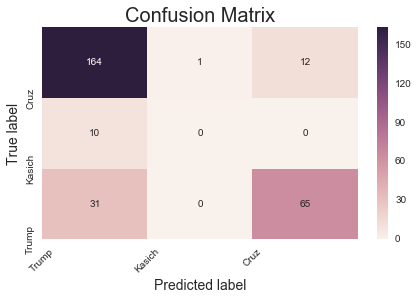

In [30]:
RF_tune_model(1)

### Apply PCA  

Principal Component Analysis:
    PST040210  PST120214  POP010210  AGE775214  SEX255214  RHI125214  \
PC                                                                     
0    0.242181   0.107170   0.242179  -0.078238   0.037342  -0.036180   
1   -0.017193   0.072816  -0.017205   0.112771   0.077200   0.193108   
2    0.077383  -0.255310   0.077381   0.165810   0.115741  -0.197318   
3    0.088180  -0.085285   0.088187   0.204078  -0.113436   0.336093   
4   -0.017352   0.030162  -0.017359  -0.031587   0.069262   0.039556   

    RHI225214  RHI325214  RHI425214  RHI525214    ...      SBO415207  \
PC                                                ...                  
0    0.021630  -0.010980   0.171829   0.045549    ...       0.075109   
1   -0.186798  -0.064831   0.041771  -0.030078    ...      -0.181628   
2    0.225490  -0.036431  -0.110104  -0.114957    ...      -0.230818   
3   -0.313786  -0.022511  -0.161572  -0.103839    ...       0.086981   
4    0.144210  -0.556022   0.0216

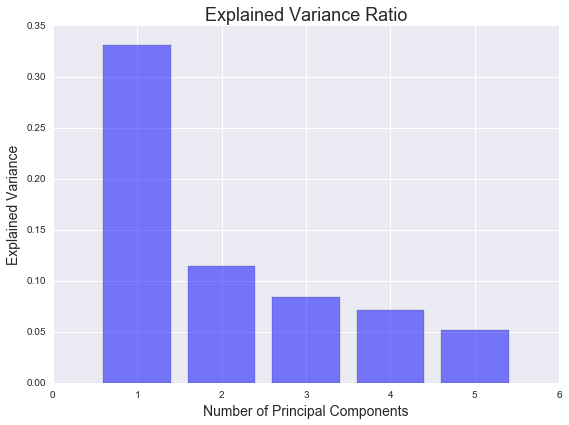

In [31]:
def doPCA():
    pca = PCA(n_components=5)
    pca.fit(df_scale)
    return pca

def plot_explained_variance(ex_var):
    pl.figure(figsize=(8,6))
    pl.bar(range(1,6), ex_var, alpha=0.5, align='center', color = 'b')
    pl.xlabel('Number of Principal Components', fontsize = 14)
    pl.ylabel('Explained Variance', fontsize =14)
    pl.title('Explained Variance Ratio', fontsize = 18)
    pl.tight_layout()
    pl.show

#Standardize features by removing the mean and scaling to unit variance
columns = X_all.columns
scale = preprocessing.scale(X_all)
df_scale = pd.DataFrame(scale, columns=columns)
#df_scale.head()

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
columns = X_all.columns
df_pca = pd.DataFrame(pca.components_, columns = columns)
df_pca.index.names = ['PC']
print "Principal Component Analysis:"
print df_pca.head()

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var)
df_var.sort(ascending=False)

df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var.head()

plot_explained_variance(ex_var)

In [32]:
X_scale = df_scale
from sklearn import decomposition

def run_RF_PCA(number_runs):
    for num in range(0, number_runs):
        start = time.time()
        X_train, X_test, y_train, y_test = Stratified_Shuffle_Split(X_scale, y_all, num_test)

        # Dimension Reduction
        pca = decomposition.RandomizedPCA(n_components=20, whiten=True)
        fit = pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf = RandomForestClassifier(n_estimators = 30)
        clf.fit(X_train_pca, y_train)
        
        pred = clf.predict(X_test_pca)
        class_report = classification_report(y_test, pred) #report
        f1 = round(f1_score(y_test, pred, average='weighted'),3) #f1 score
        
        '''Confusion Matrix: Testing Set'''
        y_true, y_pred = y_test, pred
        cm = confusion_matrix(y_true, y_pred)
        pl.figure()
        plot_confusion_matrix(cm, title='Confusion Matrix')

        print "Classification Report:"
        print class_report
        print "\nF1 Score: %s" % f1
        print "\nConfusion Matrix"
        print cm
        

Classification Report:
             precision    recall  f1-score   support

Donald_Trump       0.81      0.92      0.86       177
John_Kasich       1.00      0.10      0.18        10
   Ted_Cruz       0.78      0.67      0.72        96

avg / total       0.81      0.81      0.79       283


F1 Score: 0.791

Confusion Matrix
[[163   0  14]
 [  5   1   4]
 [ 32   0  64]]


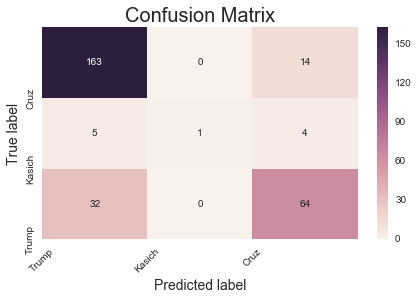

In [33]:
run_RF_PCA(1)